# TM10007 Assignment 1

IMPORTANT: the code will ask you 2 questions (Y/N) on wether you want to run parts of the code, they are not neccesary for the final classifier, they are there as means to check the methods use, may you want this. 

In [11]:
# import packages
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import (SelectKBest, VarianceThreshold,
                                       mutual_info_classif)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     learning_curve, train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# state which extra code you want to run: Plots and background explorative searches

user_input_plots = input("Y to run plot code, N to skip: ")
user_input_grid = input("Y to run explorative gridsearch, N to skip (this is not neccecary for the final chosen classifiers: ")

if user_input_plots.lower() == "y":
    print("Plots will be generated and shown")
else:
    print("Plots will not be generated")

if user_input_grid.lower() == "y":
    print("Explorative GridSearch will be run")
else:
    print("Explorative GridSearch will not be run")


Plots will not be generated
Explorative GridSearch will not be run


## Functions to split the data

In [14]:
# function to split the dataset into train and test
def split_set(X,y,test_size):

    if os.path.exists('./TEST_set.csv'):
        split_action = print('TEST_set.csv already exists')
    else:
        split_action = print('TEST_set.csv does not exist, generating new test and training sets')
        X_train_csv, X_test_csv, y_train_csv, y_test_csv = train_test_split(X, y, test_size=test_size, random_state=10)

        TESTSET = X_test_csv.merge(y_test_csv, left_index=True, right_index=True)
        TESTSET.to_csv('TEST_set.csv')

        TRAINSET = X_train_csv.merge(y_train_csv, left_index=True, right_index=True)
        TRAINSET.to_csv('TRAIN_set.csv')
        return split_action

## Setting up the data to be processed

In [16]:
data = pd.read_csv(os.path.join('Lipo_radiomicFeatures.csv'), index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(type(data))

# change lipoma = 1 and liposarcoma = 0 and encode labels
group_names = list(set(data.label))
data.loc[data['label'] == 'lipoma', 'label'] = 1
data.loc[data['label'] == 'liposarcoma', 'label'] = 0
data['label'] = pd.cut(data['label'], bins = 2, labels=group_names)
print(data['label'].unique())
label_diag = LabelEncoder()
data['label'] = label_diag.fit_transform(data['label'])

# assign X to measurements and y to outcome (lipoma/sarcoma)
X = data.drop('label', axis=1)
y = data['label']
test_size = 0.3

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
['liposarcoma', 'lipoma']
Categories (2, object): ['liposarcoma' < 'lipoma']


In [17]:
# code that splits the data into test and validation sets if this is not done already
split_set(X,y,test_size)

TEST_set.csv already exists


## Import the training set

In [18]:
# import
TRAIN = pd.read_csv('TRAIN_set.csv', index_col=0)
X_train = TRAIN.drop('label', axis=1)
y_train = TRAIN['label']

TRAIN['label'] = pd.cut(TRAIN['label'], bins = 2, labels=group_names)
print(TRAIN['label'].unique())
label_diag = LabelEncoder()
TRAIN['label'] = label_diag.fit_transform(TRAIN['label'])

# split into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=10)
print(f'Size before preprocess: ', X_train.shape)

['liposarcoma', 'lipoma']
Categories (2, object): ['liposarcoma' < 'lipoma']
Size before preprocess:  (56, 493)


# Optimize the best estimator from the gridsearch

In [19]:
# set up pipeline steps
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
variance = VarianceThreshold(threshold=0)
pca = PCA(random_state=1)

# grid search SVC
pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('variance', variance), ('pca', pca), ('classifier', SVC(probability=True, random_state=8, max_iter=1000))])

param_grid = {}
param_grid['classifier__C'] = [0.1, 1, 5, 10, 15, 20]
param_grid['classifier__class_weight'] = [None]
param_grid['classifier__kernel'] = ['linear', 'rbf', 'poly', 'sigmoid']
param_grid['pca__n_components'] = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

gsb = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, scoring='accuracy').fit(X_train, y_train)
best_clf1 = gsb.best_estimator_
print(best_clf1)

# grid search logistic regression
pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('variance', variance), ('kbest', SelectKBest(mutual_info_classif)), ('classifier', LogisticRegression(random_state=3))])

param_grid = {}
param_grid['classifier__C'] = [0.1, 1, 10]
param_grid['classifier__class_weight'] = [None]
param_grid['classifier__penalty'] = [None, 'l2']
param_grid['kbest__k'] = [8, 9, 10, 11, 12]

gsb = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, scoring='recall').fit(X_train, y_train)
best_clf2 = gsb.best_estimator_
print(best_clf2)

c:\ProgramData\miniconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0)),
                ('pca', PCA(n_components=16, random_state=1)),
                ('classifier',
                 SVC(C=10, kernel='linear', max_iter=1000, probability=True,
                     random_state=8))])
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0)),
                ('kbest',
                 SelectKBest(score_func=<function mutual_info_classif at 0x0000020C615C8CA0>)),
                ('classifier', LogisticRegression(C=10, random_state=3))])


## Create ensemble

In [8]:
# ensemble of SVC and logistic regression classifiers
eclf1 = VotingClassifier(estimators=[('lr', best_clf1), ('rf', best_clf2)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
pred_rfc = eclf1.predict(X_valid)
print('rfc', classification_report(y_valid, pred_rfc))
print(confusion_matrix(y_valid, pred_rfc))
print("Test Precision:",precision_score(eclf1.predict(X_valid), y_valid))
print("Test Recall:",recall_score(eclf1.predict(X_valid), y_valid))
print("Test ROC AUC Score:",roc_auc_score(eclf1.predict(X_valid), y_valid))

C:\Users\ethie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


rfc               precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.83      0.77      0.80        13

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.80      0.79      0.79        24

[[ 9  2]
 [ 3 10]]
Test Precision: 0.7692307692307693
Test Recall: 0.8333333333333334
Test ROC AUC Score: 0.7916666666666666


## Run classifier on test set

In [9]:
# import the test set
TEST = pd.read_csv('TEST_set.csv', index_col=0)
X_test = TEST.drop('label', axis=1)
y_test = TEST['label']

TEST['label'] = pd.cut(TEST['label'], bins = 2, labels=group_names)
label_diag = LabelEncoder()
TEST['label'] = label_diag.fit_transform(TEST['label'])

# predict
pred_test = eclf1.predict(X_test)

# results 
print('Test classification report \n', classification_report(y_test, pred_test))
print("Test Precision:    ",precision_score(eclf1.predict(X_test), y_test))
print("Test Recall:       ",recall_score(eclf1.predict(X_test), y_test))
print("Test ROC AUC Score:",roc_auc_score(eclf1.predict(X_test), y_test))
 
print('confusion matrix \n', confusion_matrix(y_test, pred_test))

Test classification report 
               precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.79      0.61      0.69        18

    accuracy                           0.71        35
   macro avg       0.73      0.72      0.71        35
weighted avg       0.73      0.71      0.71        35

Test Precision:     0.6111111111111112
Test Recall:        0.7857142857142857
Test ROC AUC Score: 0.7261904761904762
confusion matrix 
 [[14  3]
 [ 7 11]]


## PLOTS - ROC curve

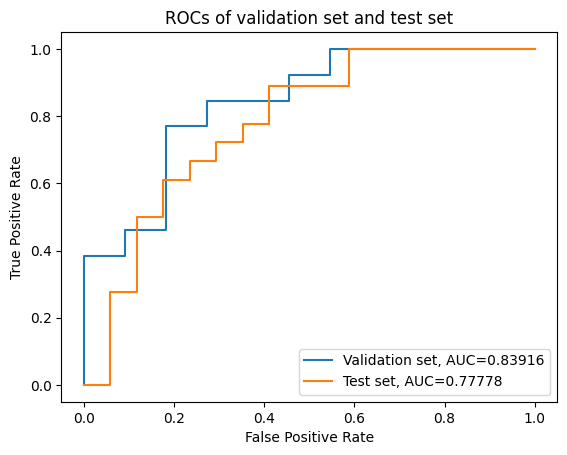

In [10]:
if user_input_plots.lower() == 'y':
    pred_val = eclf1.predict_proba(X_valid)[:,1]

    fpr_val, tpr_val, _ = metrics.roc_curve(y_valid, pred_val)
    auc_val = metrics.roc_auc_score(y_valid, pred_val)

    pred_test = eclf1.predict_proba(X_test)[:,1]

    fpr_test, tpr_test, _ = metrics.roc_curve(y_test, pred_test)
    auc_test = metrics.roc_auc_score(y_test, pred_test)

    plt.plot(fpr_val,tpr_val,label="Validation set, AUC="+str(round(auc_val, 5)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROCs of validation set and test set')
    plt.legend(loc=4)

    plt.plot(fpr_test, tpr_test,label='Test set, AUC='+str(round(auc_test,5)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## PLOTS - Learning curve

C:\Users\ethie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ethie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ethie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\ethie\AppData\Local\Packages\PythonSoftwareFoundatio

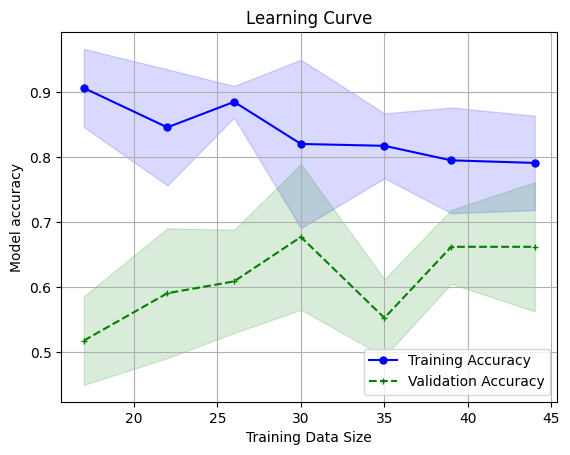

In [14]:
if user_input_plots.lower() == 'y':
    train_sizes, train_scores, test_scores = learning_curve(estimator=eclf1, X=X_train, y=y_train,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1, random_state=42)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

# Orientation: Classifiers, Cross Validation, Feature Selection/Extraction

## Gridsearch for best classifiers

In [12]:
if user_input_grid.lower() == 'y':
    N_FEATURES_OPTIONS = [5, 10, 15, 25, 30, 40]

    # set up pipeline steps
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    variance = VarianceThreshold(threshold=0)
    pca = PCA()

    # set up classifiers
    clf1 = RandomForestClassifier(random_state=1)
    clf2 = SVC(probability=True, random_state=1, max_iter=1000)
    clf3 = LogisticRegression(random_state=1)
    clf4 = DecisionTreeClassifier(random_state=1)
    clf5 = KNeighborsClassifier()
    clf6 = MultinomialNB()

    pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('variance', variance), ('pca', pca), ('classifier', clf2)])

    # set up parameters
    param1 = {}
    param1['classifier__n_estimators'] = [1,10, 50, 100, 250]
    param1['classifier__max_depth'] = [5, 10, 20]
    param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
    param1['pca__n_components'] = N_FEATURES_OPTIONS
    param1['classifier'] = [clf1]

    param2 = {}
    param2['classifier__C'] = [0.1, 1, 10, 100]
    param2['classifier__class_weight'] = [None]
    param2['classifier__kernel'] = ['sigmoid']
    param2['pca__n_components'] = N_FEATURES_OPTIONS
    param2['classifier'] = [clf2]

    param3 = {}
    param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
    param3['classifier__penalty'] = [None, 'l2']
    param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}]
    param3['pca__n_components'] = N_FEATURES_OPTIONS
    param3['classifier'] = [clf3]

    param4 = {}
    param4['classifier__max_depth'] = [5,10,25,None]
    param4['classifier__min_samples_split'] = [2,5,10]
    param4['classifier__class_weight'] = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}]
    param4['pca__n_components'] = N_FEATURES_OPTIONS
    param4['classifier'] = [clf4]

    param5 = {}
    param5['classifier__n_neighbors'] = [2,5,10,25,50]
    param5['pca__n_components'] = N_FEATURES_OPTIONS
    param5['classifier'] = [clf5]

    param6 = {}
    param6['classifier__alpha'] = [10**0, 10**1, 10**2]
    param6['pca__n_components'] = N_FEATURES_OPTIONS
    param6['classifier'] = [clf6]

    param_grid = [param1, param2, param3, param4, param5, param6]

    grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)
    print(grid.best_score_)

    # Test data performance
    print("Test Precision:",precision_score(grid.predict(X_valid), y_valid))
    print("Test Recall:",recall_score(grid.predict(X_valid), y_valid))
    print("Test ROC AUC Score:",roc_auc_score(grid.predict(X_valid), y_valid))

    best_clf = grid.best_estimator_
    best_clf.fit(X_train,y_train)
    pred_rfc = best_clf.predict(X_valid)

    print('rfc', classification_report(y_valid, pred_rfc))
    print(confusion_matrix(y_valid, pred_rfc))

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by=['rank_test_score'])
    results.to_csv('results')

## Cross Validation KFold selection

In [13]:
if user_input_plots.lower() == 'y':
    # Trying differen K folds in cross validation per classifier
    # Used to give us an idea on which Kfold to use

    # function
    def perform_cross_validation(clf, k_values, X_train, y_train):
        best_k = None
        best_score = None
        results = []
        for k in k_values:
            kf = KFold(n_splits=k, shuffle=True, random_state=10)
            scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
            mean_score = np.mean(scores)
            results.append((k, scores))
            if best_score is None or mean_score > best_score:
                best_k = k
                best_score = mean_score
        return best_k, results

    classifiers = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(),
        SVC()
        # MultinomialNB() is left out because it requires different scaled data (MinMax scaler) to work in this code.
    ]

    k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    best_k_values = {}
    results = []

    for clf in classifiers:
        clf_name = type(clf).__name__
        best_k, cv_results = perform_cross_validation(clf, k_values, X_train, y_train)
        best_k_values[clf_name] = best_k
        results.append((clf_name, cv_results))
        print(f"The best k-fold value for {clf_name} is {best_k} with a mean accuracy of {np.max([np.mean(cv_scores) for _, cv_scores in cv_results]):.3f}")

    for clf_name, cv_results in results:
        fig, ax = plt.subplots()
        scores = [np.mean(cv_scores) for _, cv_scores in cv_results]
        ax.plot(k_values, scores)
        ax.scatter(best_k_values[clf_name], np.max(scores), marker='*', s=200, color='r', zorder=10)
        ax.set_xlabel('Number of Folds (k)')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{clf_name} Cross-Validation Performance')
        plt.show()

## PLOTS - Number of features - SVM

In [14]:
if user_input_plots.lower() == 'y':
    pipe = Pipeline([
        ('scaling', StandardScaler()),
        ('reduce_dim', 'passthrough'),
        ('classify', SVC(kernel='sigmoid', max_iter=1000, random_state=1))
    ])

    N_FEATURES_OPTIONS = [5, 10, 15, 20, 25, 30, 35, 40]
    C_OPTIONS = [0.1, 1, 10, 25]
    param_grid = [
        {
            'reduce_dim': [PCA()],
            'reduce_dim__n_components': N_FEATURES_OPTIONS,
            'classify__C': C_OPTIONS
        },
        {
            'reduce_dim': [SelectKBest(mutual_info_classif)],
            'reduce_dim__k': N_FEATURES_OPTIONS,
            'classify__C': C_OPTIONS
        }
    ]
    reducer_labels = ['PCA', 'KBest(mutual_info_classif)']

    grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, scoring='accuracy')
    grid.fit(X_train, y_train)

    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    # scores are in the order of param_grid iteration, which is alphabetical
    mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
    # select score for best C
    mean_scores = mean_scores.max(axis=0)
    mean_scores = pd.DataFrame(
        mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
    )

    print(grid.best_estimator_)

    # plot barplot with results
    ax = mean_scores.plot.bar()
    ax.set_title("Comparing feature selection/extraction techniques - SVM")
    ax.set_xlabel("Reduced number of features")
    ax.set_ylabel("Digit classification accuracy")
    ax.set_ylim((0, 1))
    ax.legend(loc="upper left")

    plt.show()

## PLOTS - Number of features - Logistic Regression

In [15]:
if user_input_plots.lower() == 'y':
    pipe = Pipeline([
        ('scaling', StandardScaler()),
        ('reduce_dim', 'passthrough'),
        ('classify', LogisticRegression(max_iter=1000, random_state=2))
    ])

    N_FEATURES_OPTIONS = [5, 10, 15, 20, 25, 30, 35, 40]
    C_OPTIONS = [0.01, 0.1, 1, 10, 25]
    param_grid = [
        {
            'reduce_dim': [PCA()],
            'reduce_dim__n_components': N_FEATURES_OPTIONS,
            'classify__C': C_OPTIONS
        },
        {
            'reduce_dim': [SelectKBest(mutual_info_classif)],
            'reduce_dim__k': N_FEATURES_OPTIONS,
            'classify__C': C_OPTIONS
        }
    ]
    reducer_labels = ['PCA', 'KBest(mutual_info_classif)']

    grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, scoring='recall')
    grid.fit(X_train, y_train)

    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    # scores are in the order of param_grid iteration, which is alphabetical
    mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
    # select score for best C
    mean_scores = mean_scores.max(axis=0)
    mean_scores = pd.DataFrame(
        mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
    )

    print(grid.best_estimator_)

    # plot barplot with results
    ax = mean_scores.plot.bar()
    ax.set_title("Comparing feature selection/extraction techniques - Logistic Regression")
    ax.set_xlabel("Reduced number of features")
    ax.set_ylabel("Digit classification accuracy")
    ax.set_ylim((0, 1))
    ax.legend(loc="upper left")

    plt.show()